# Coupled Laser Simulations

## Imports and Defining Global Constants

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from jitcxde_common import conditional
import symengine
from symengine import sin, cos
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy import stats
from tqdm import tqdm
import time

In [2]:
# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters shared by all lasers
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)
# See Ohtsubo pg. 37 for below details. Numbers for a InGaAsP laser
nu = 3.6              # Refractive index (dimensionless)
nu_e = 4              # Effective refractive index (dimensionless)
l = 250e-6            # Laser length (m)
tau_in = 2 * nu_e * l / c # Round trip time of light in laser cavity (s)

# Typical values for lasers (not necessarily used, but may be referenced for convenience)
wavelength_typ = 655e-9   # Laser wavelength (655 nm)
frequency_typ = c / wavelength_typ  # f = c / λ - QUESTION: shouldn't the index of refraction of the laser medium be inserted in below calculation?
omega_typ = 2 * np.pi * frequency_typ # typical laser frequency in rad/s
I_th = 17.35e-3       # Threshold current (= 17.35mA)
r_0 = (nu - 1) / (nu + 1) # Internal amplitude reflectivity for a cleaved facet (see Ohtsubo pg. 84)

## Define Simulation Functions (only run one of below)

### Old Versions (fast)

In [3]:
# Generates Lang-Kobayashi Differential Equations for a system of lasers of specified parameters
# Returns equations in order: laser #1 real E, laser #1 imaginary E, laser #1 carrier density, laser #2 real E, ...
def generate_equations(num_lasers, omegas, kappas, taus, I_injection_symbols):
    # State variables 
    # Each laser has 3 independent variables: real component of E field, imaginary component of E field, and carrier density
    # in total there are num_lasers*3 variables
    E_Rs = [] # Real part of electric field
    E_Is = [] # Imaginary part of electric field
    Ns = [] # Carrier density
    
    for i in range(num_lasers):
        E_Rs.append(y(i * 3))
        E_Is.append(y(i * 3 + 1))
        Ns.append(y(i * 3 + 2))
    
    #print(f"E_Rs: {E_Rs}, E_Is: {E_Is}, Ns: {Ns}")
    
    # Delayed variables are added in the equation itself
    
    # The intensity and gain are dependent on E and N
    intensities = []
    gains = []
    
    # Intensities
    for i in range(num_lasers):
        intensities.append(E_Rs[i]**2 + E_Is[i]**2)
    
    # Net Gains
    for i in range(num_lasers):
        gains.append( (g * (Ns[i] - N_0) / (1 + s * intensities[i])) ) 
    
    # Equations for derivatives
    dE_R_dts = []
    dE_I_dts = []
    dN_dts = []
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        dE_R_dt += (kappas[j][j] / tau_in) * ( y(j * 3, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) - y(j * 3 + 1, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_R_dt += (kappas[j][k] / tau_in) * ( y(k * 3, t - taus[j][k]) * cos(delta_omega * taus[j][k]) + y(k * 3 + 1, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_R_dts.append(dE_R_dt)
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        dE_I_dt += (kappas[j][j] / tau_in) * ( y(j * 3 + 1, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) + y(j * 3, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_I_dt += (kappas[j][k] / tau_in) * ( y(k * 3 + 1, t - taus[j][k]) * cos(delta_omega * taus[j][k]) - y(k * 3, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_I_dts.append(dE_I_dt)
    
        dN_dt = (I_injection_symbols[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts.append(dN_dt)
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = []
    for i in range(num_lasers):
        equations.append(dE_R_dts[i])
        equations.append(dE_I_dts[i])
        equations.append(dN_dts[i])

    return equations

In [4]:
# Simulates the laser system with the given parameters
# Returns lists of times in s, intensities, and carrier densities
# I_injections is a list of lists of current values to be injected at the times specified
# by the values in the list I_times (in s)
def simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics):
    assert len(I_injections[0]) == len(I_times), "Must have same number of injection times as injection currents"
    assert len(I_injections[0]) > 0, "Must have at least one initial injection current, at time = 0"
    # Symengine symbols for the injection currents
    I_injection_symbols = []
    for i in range(num_lasers):
        I_injection_symbols.append(symengine.symbols("I_injection_" + str(i)))

    # Initialize the solver
    equations = generate_equations(num_lasers, omegas, kappas, taus, I_injection_symbols)
    dde = jitcdde(equations, control_pars=I_injection_symbols, verbose=False) # Set verbose=True for debugging
    #dde = jitcdde(generate_equations(num_lasers, omegas, kappas, taus, I_injections), verbose=False) # Set verbose=True for debugging
    
    # If integration doesn't work, try reducing min_step or loosening tolerances
    #dde.set_integration_parameters(rtol=1e-4, atol=1e-6)
    dde.set_integration_parameters(rtol=1e-4, atol=1e-6, min_step=1e-15)
    #dde.set_integration_parameters(min_step=1e-15)
    #dde.set_integration_parameters(atol=0, rtol=1e-6, min_step=1e-15)
        
    dde.constant_past(ics)
    
    # Start the simulation
    dde.step_on_discontinuities()

    # Time array
    times = np.arange(dde.t, dde.t + sim_time, dt)
    outputs = []

    current_I_time_idx = 0
    for time in times:
        # Update the injection current if time has passed beyond update point
        if (current_I_time_idx < len(I_times)) and (time >= I_times[current_I_time_idx]): # and statement will short circuit on last time
            params = []
            for i in range(num_lasers):
                params.append(I_injections[i][current_I_time_idx])
            dde.set_parameters(*params)
            #dde.step_on_discontinuities()

            # This is used to fix discontinuities after changing injection current. Increasing shift_ratio reduces spikes.
            # 0.1 works acceptably well (carrier density spikes (errors) are around 1%)
            # 1 gets rid of spikes almost completely
            dde.adjust_diff(shift_ratio=1) # default is shift_ratio=0.0001
            
            current_I_time_idx += 1
        
        state = dde.integrate(time)
        #state = dde.integrate_blindly(time)
        outputs.append(state)
    
    #print("Finished solving system.")
    
    outputs = np.array(outputs)
    
    # Extract results from output
    E_R_ts = []
    E_I_ts = []
    N_ts = []
    
    for i in range(num_lasers):
        E_R_ts.append(outputs[:, i * 3])
        E_I_ts.append(outputs[:, i * 3 + 1])
        N_ts.append(outputs[:, i * 3 + 2])
    
    # Compute intensities
    I_ts = []
    for i in range(num_lasers):
        I_ts.append(E_R_ts[i]**2 + E_I_ts[i]**2)

    return times, I_ts, N_ts

### New Smoothed Versions (slow)

In [51]:
# New smoothed version
# Generates Lang-Kobayashi Differential Equations for a system of lasers of specified parameters
# Returns equations in order: laser #1 real E, laser #1 imaginary E, laser #1 carrier density, laser #2 real E, ...
def generate_equations(num_lasers, omegas, kappas, taus, I_injections, I_times):
    # Calculate incremental changes in injection current (halves the number of conditionals needed)
    I_injection_increments = []
    for i in range(num_lasers):
        prev_I = 0
        I_injection_increment = []
        for j in range(len(I_injections[i])):
            I_injection_increment.append(I_injections[i][j] - prev_I)
            prev_I = I_injections[i][j]
        I_injection_increments.append(I_injection_increment)
    print(I_injection_increments)
        
    # State variables 
    # Each laser has 3 independent variables: real component of E field, imaginary component of E field, and carrier density
    # in total there are num_lasers*3 variables
    E_Rs = [] # Real part of electric field
    E_Is = [] # Imaginary part of electric field
    Ns = [] # Carrier density
    
    for i in range(num_lasers):
        E_Rs.append(y(i * 3))
        E_Is.append(y(i * 3 + 1))
        Ns.append(y(i * 3 + 2))
    
    #print(f"E_Rs: {E_Rs}, E_Is: {E_Is}, Ns: {Ns}")
    
    # Delayed variables are added in the equation itself
    
    # The intensity and gain are dependent on E and N
    intensities = []
    gains = []
    
    # Intensities
    for i in range(num_lasers):
        intensities.append(E_Rs[i]**2 + E_Is[i]**2)
    
    # Net Gains
    for i in range(num_lasers):
        gains.append( (g * (Ns[i] - N_0) / (1 + s * intensities[i])) ) 
    
    # Equations for derivatives
    dE_R_dts = []
    dE_I_dts = []
    dN_dts = []
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        dE_R_dt += (kappas[j][j] / tau_in) * ( y(j * 3, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) - y(j * 3 + 1, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_R_dt += (kappas[j][k] / tau_in) * ( y(k * 3, t - taus[j][k]) * cos(delta_omega * taus[j][k]) + y(k * 3 + 1, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_R_dts.append(dE_R_dt)
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        dE_I_dt += (kappas[j][j] / tau_in) * ( y(j * 3 + 1, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) + y(j * 3, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_I_dt += (kappas[j][k] / tau_in) * ( y(k * 3 + 1, t - taus[j][k]) * cos(delta_omega * taus[j][k]) - y(k * 3, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_I_dts.append(dE_I_dt)

        dN_dt = -1 * gamma_e * Ns[j] - gains[j] * intensities[j]
        # Append all sources of current, treated as smoothed step functions one after the other
        for i in range(len(I_injection_increments[j])):
            dN_dt += conditional(t, I_times[i], 0, I_injection_increments[j][i]) / e_charge
        dN_dts.append(dN_dt)
    
    print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = []
    for i in range(num_lasers):
        equations.append(dE_R_dts[i])
        equations.append(dE_I_dts[i])
        equations.append(dN_dts[i])

    return equations

In [52]:
# New smoothed version
# Simulates the laser system with the given parameters
# Returns lists of times in s, intensities, and carrier densities
# I_injections is a list of lists of current values to be injected at the times specified
# by the values in the list I_times (in s)
def simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics):
    assert len(I_injections[0]) == len(I_times), "Must have same number of injection times as injection currents"
    assert len(I_injections[0]) > 0, "Must have at least one initial injection current, at time = 0"

    # Initialize the solver
    equations = generate_equations(num_lasers, omegas, kappas, taus, I_injections, I_times)
    dde = jitcdde(equations, verbose=False) # Set verbose=True for debugging
    
    # If integration doesn't work, try reducing min_step or loosening tolerances
    #dde.set_integration_parameters(rtol=1e-4, atol=1e-6)
    dde.set_integration_parameters(rtol=1e-4, atol=1e-6, min_step=1e-15)
    #dde.set_integration_parameters(min_step=1e-15)
    #dde.set_integration_parameters(atol=0, rtol=1e-6, min_step=1e-15)
        
    dde.constant_past(ics)
    
    # Start the simulation
    dde.step_on_discontinuities()

    # Time array
    times = np.arange(dde.t, dde.t + sim_time, dt)
    #times = np.arange(0, sim_time, dt)
    outputs = []

    current_I_time_idx = 0
    for time in times:
        state = dde.integrate(time)
        #state = dde.integrate_blindly(time)
        outputs.append(state)
    
    #print("Finished solving system.")
    
    outputs = np.array(outputs)
    
    # Extract results from output
    E_R_ts = []
    E_I_ts = []
    N_ts = []
    
    for i in range(num_lasers):
        E_R_ts.append(outputs[:, i * 3])
        E_I_ts.append(outputs[:, i * 3 + 1])
        N_ts.append(outputs[:, i * 3 + 2])
    
    # Compute intensities
    I_ts = []
    for i in range(num_lasers):
        I_ts.append(E_R_ts[i]**2 + E_I_ts[i]**2)

    return times, I_ts, N_ts

## Define Analysis Functions

In [81]:
# Calculate what a single, uncoupled laser would output at a given current
# Slope Efficiency: 1.225288e+07 Intercept: -2.125500e+05
standard_slope_efficiency = 1.225288e+07 # Found in One Laser, Experiment 3
def calc_single_laser_power(current):
    if current > I_th:
        #return 1.225288e+07 * current - 2.125500e+05
        return standard_slope_efficiency * (current - I_th)
    else:
        return 0

In [6]:
# Apply lowpass filter to emulate the limited frequency response of a photodiode
# Data is a list of lists of either intensities or carrier densities
# fs is the sampling frequency, equal to 1 / dt
# By default, a 1st-order Butterworth Filter (acts like a simple RC filter) is applied at 10 MHz
# Increase order for better filter performance
def apply_lowpass_filter(data, fs, cutoff=10e6, order=1):
    filtered_data = []
    normal_cutoff = cutoff / (0.5 * fs) # Divide by Nyquist frequency, which is half of the sampling frequency
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    for i in range(len(data)):
        filtered_data.append(filtfilt(b, a, data[i]))

    return filtered_data

In [7]:
# Take FFT of either intensities or carrier densities
# Times are times in s
# data is a list of lists of either intensities or carrier densities
# dt is the time between samples (equivalent to times[x + 1] - times[x])
# returns a list of frequency bins and a list of lists of frequency spectra
def take_fft(times, data, dt):
    # Take FFT of all intensity spectrums for entire time period
    freqs = rfftfreq(len(times), dt)

    spectrums = []
    for i in range(len(data)):
        c_spectrum = rfft(I_ts[i])
        mag_spectrum = np.abs(c_spectrum)
        mag_spectrum = mag_spectrum / len(freqs) # Divide by N to normalize the result
        spectrums.append(mag_spectrum)
        
    return freqs, spectrums

In [53]:
# Calculates mean and standard deviation of data
# times is a list in s, data is a list of lists of intensities or carrier densities
# begin and end time are in ns
def calc_mean_and_relative_stddev(times, data, begin_time=0, end_time=None):
    if end_time == None:
        end_time = times[-1]

    times = np.asarray(times)
    data = np.asarray(data)
    
    means = []
    relative_stddevs = []
    
    for i in range(len(data)):
        data_truncated = data[i][times >= (begin_time * 1e-9)]
        mean = np.mean(data_truncated)
        means.append(mean)
        relative_stddevs.append(np.std(data_truncated) / mean)

    return means, relative_stddevs

In [8]:
# TODO: cross correlation and phase sync calculations

#cross_corr_values = []
#phase_sync_indices = []
    
# Compute cross-correlation
#corr = np.correlate(I1_t_trimmed - np.mean(I1_t_trimmed), I2_t_trimmed - np.mean(I2_t_trimmed), mode='full')
#max_corr = np.max(corr)
#cross_corr_values.append(max_corr)

# Phase synchronization analysis
# phi_1_t = np.unwrap(np.arctan2(E_I1_t[transient_cutoff:], E_R1_t[transient_cutoff:]))
# phi_2_t = np.unwrap(np.arctan2(E_I2_t[transient_cutoff:], E_R2_t[transient_cutoff:]))
# delta_phi_t = phi_1_t - phi_2_t
# R = np.abs(np.mean(np.exp(1j * delta_phi_t)))
# phase_sync_indices.append(R)

## Define Plotting Functions

In [8]:
# Plot and save multiple laser intensities over a time interval
# times is a list of times in s
# intensities is a list of lists of intensities
# begin and end times are in ns
def plot_intensities(times, intensities, begin_time=0, end_time=0, filename="intensities.png"):
    times_ns = times * 1e9
    if end_time == 0:
        end_time = times_ns[-1]

    plt.figure(figsize=(12, 6))
    for i in range(len(intensities)):
        plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], intensities[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
    
    plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
    plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Intensities",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()
    
    plt.savefig(filename)
    plt.show()

In [9]:
# Plot and save multiple carrier densities over a time interval
# times is a list of times in s
# carrier_densities is a list of lists of carrier densities
# begin and end times are in ns
def plot_carrier_densities(times, carrier_densities, begin_time=0, end_time=0, filename="carrier_densities.png"):
    times_ns = times * 1e9
    if end_time == 0:
        end_time = times_ns[-1]
        
    plt.figure(figsize=(12, 6))
    for i in range(len(carrier_densities)):
        plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], carrier_densities[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
    
    plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
    plt.ylabel("Carrier Densities [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Carrier Densities",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()

    plt.savefig(filename)
    plt.show()

In [10]:
# Plot spectrum of fft (can be fft of intensities or carrier densities) and print average DC value of each laser
# freqs is a list of frequencies in Hz
# mags is a list of lists of normalized (meaning already divided by N) magnitudes (real, not complex) from the FFT
# begin and end freqs are in MHz. end freq defaults to 1000 MHz
def plot_fft_spectrum(freqs, mags, begin_freq=0, end_freq=1000, filename="fft_spectrum.png"):
    freqs_mhz = freqs / 1e6
    
    # Plot frequency spectrum in certain range
    plt.figure(figsize=(12, 6))
    
    for i in range(len(mags)):
        plt.plot(freqs_mhz[(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], mags[i][(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], label=f"Laser {i}")
    
    # Logarithmic y axis
    plt.yscale('log')
    plt.xlabel("Frequency [MHz]", fontsize=14, fontweight='bold')
    plt.ylabel("Magnitude [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Frequency Spectrum",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()
    
    plt.savefig(filename)
    plt.show()
    
    # Print average (DC) value
    for i in range(len(mags)):
        print(f"Avg normalized DC value of laser {i}: {spectrums[i][0]:.2e}")

## General Simulation Parameters

In [107]:
# Simulation parameters
# Time parameters
sim_time = 200e-9  # Total simulation time in seconds (1000ns)
dt = 0.01e-9     # Time step in seconds (0.01ns)

## One Laser Simulations

### Feedback Coefficient $\kappa$

Assuming the reflectivities for the front and back facets are both $r_0$, (see Ohtsubo pg. 87)

\begin{equation}
\kappa = (1-r_0^2)\frac{r}{r_0}
\end{equation}

where $r$ is the external reflection.

### C Parameter for self-feedback

\begin{equation}
C = \frac{\kappa \tau}{\tau_{in}} \sqrt{1 + \alpha^2}
\end{equation}

When $C < 1$, the solitary laser is stable and no chaotic oscillations can be observed. (see Ohtsubo pg. 89)

In [73]:
# Sample calculations of kappa and C
r = 0.1
tau = 0.1e-9
print(f"Internal reflection (power): {100*r_0**2:.2f}%")
print(f"External reflection (power): {100*r**2:.2f}%")
print(f"Cavity internal round trip time (ps): {1e12 * tau_in:.2f}")
print(f"kappa = {(1 - r_0**2) * r / r_0:.4f}")
print(f"C = {((1 - r_0**2) * r / r_0) * tau * math.sqrt(1 + alpha**2) / tau_in:.2f}")

Internal reflection (power): 31.95%
External reflection (power): 1.00%
Cavity internal round trip time (ps): 6.67
kappa = 0.1204
C = 5.71


### Set Initial and Default Conditions

In [13]:
num_lasers = 1

# Angular frequencies of lasers in rad/s
# Frequency differences are calculated in equations
omegas = [omega_typ for i in range(num_lasers)]

# Coupling constants (initialized to no coupling)
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575
taus = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Delay time in s

# Injection currents in A
I_injections = [] # Now a 2d list
I_injections.append([I_th])

# Injection times in s (at least one initial time is required)
# For some reason, initial time = 0 doesn't work so we set it to 1ns
I_times = [1e-9]

# Initial conditions for 1 laser case
E_R_0s = [1e-6]
E_I_0s = [0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init]
#N_0s = [0]

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### One Laser, Experiment #1: no self-coupling, driving at threshold

In [29]:
# Default conditions are sufficient
# No self-coupling
kappas[0][0] = 0
taus[0][0] = 0

In [33]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

/tmp/ipykernel_739868/887330754.py:32: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


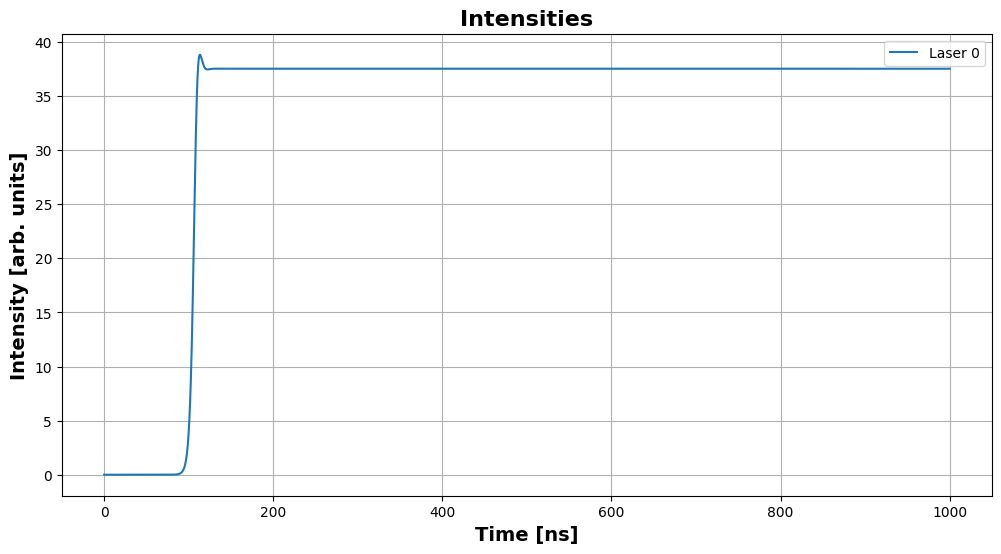

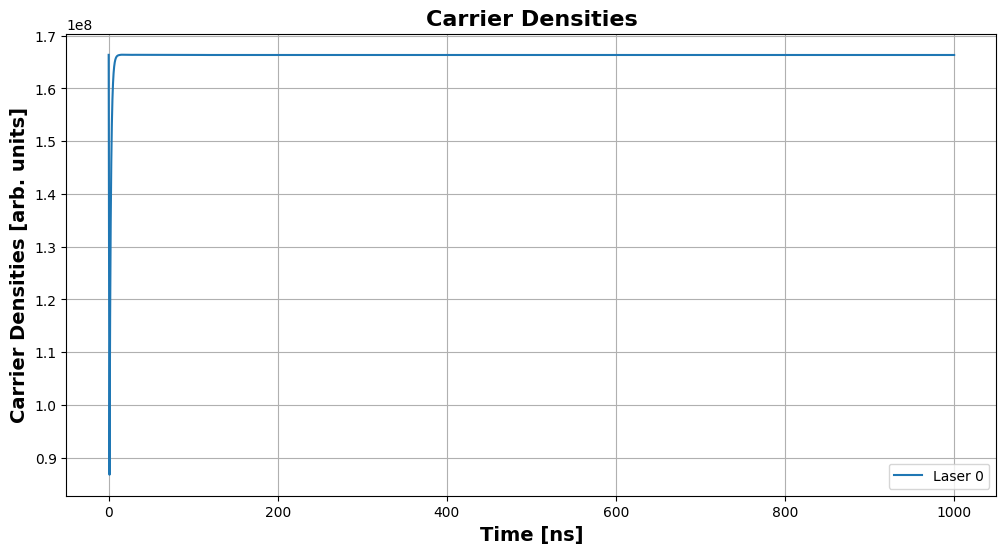

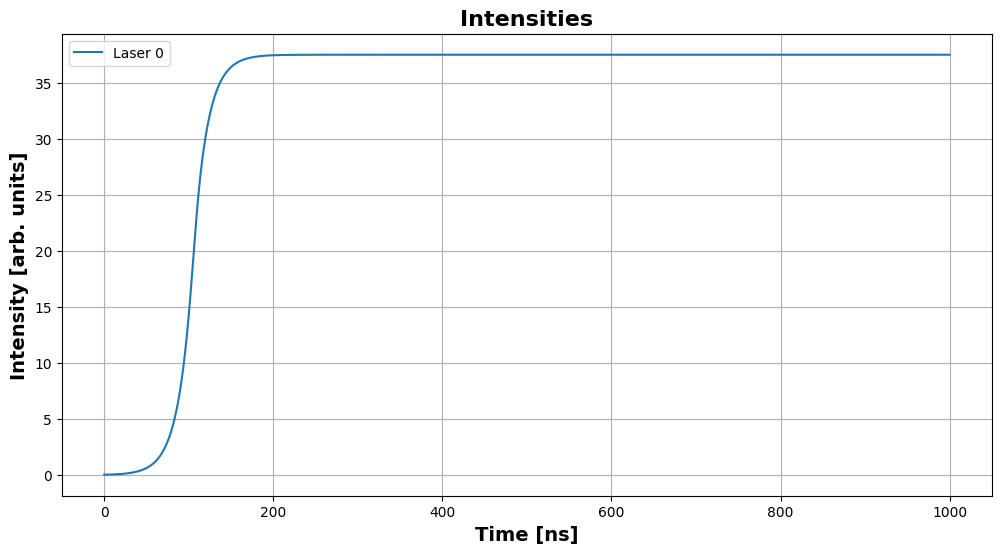

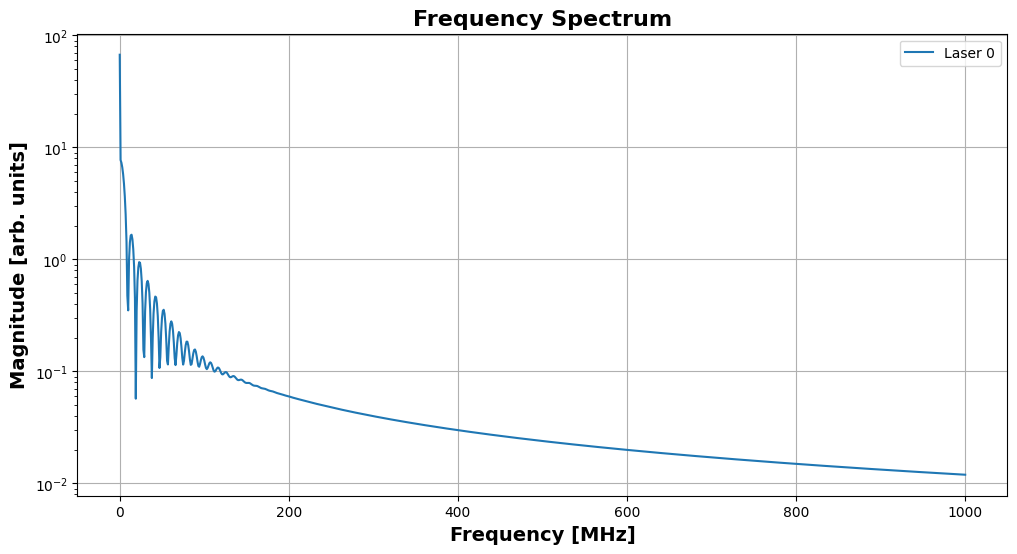

Avg normalized DC value of laser 0: 6.72e+01


In [31]:
plot_intensities(times, I_ts, filename="1laser_0kappa_0ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_0kappa_0ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_0kappa_0ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0kappa_0ns_threshold_intensity_fft.png")

### One Laser, Experiment #2: weak self-coupling, driving at threshold

In [40]:
# Set constants and ICs for a single, self coupled laser at threshold
kappas[0][0] = 1
taus[0][0] = 1e-9 # 1 ns self-couple delay

In [41]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

/tmp/ipykernel_1540549/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


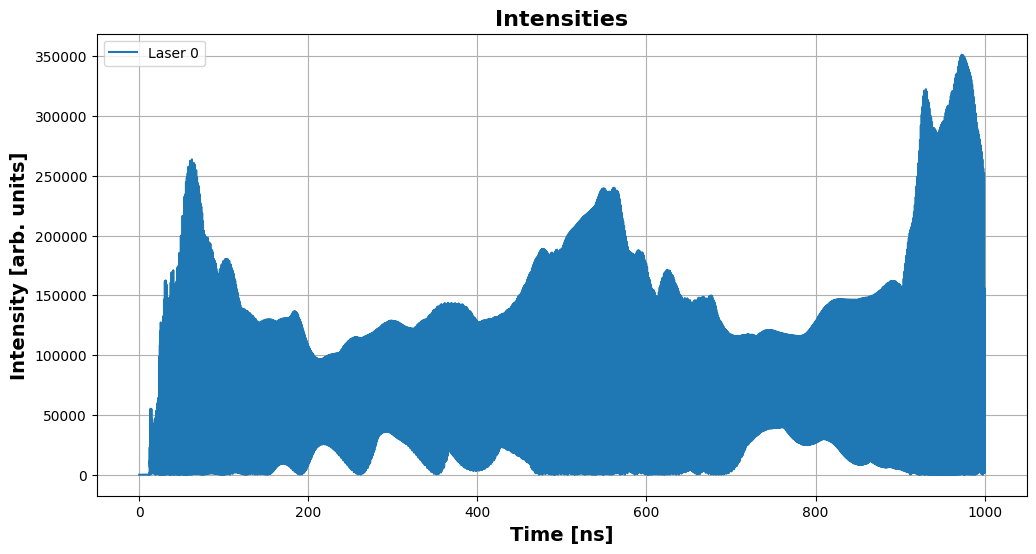

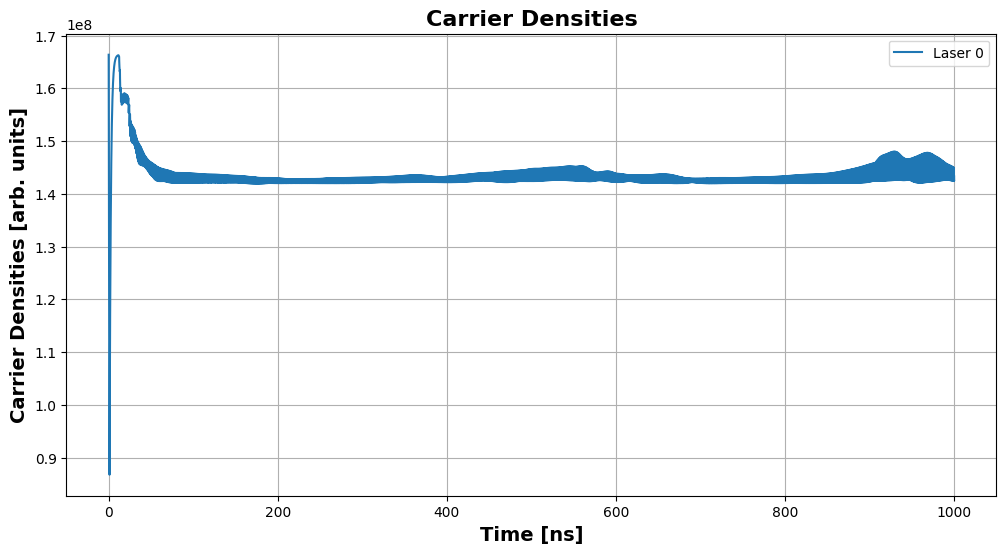

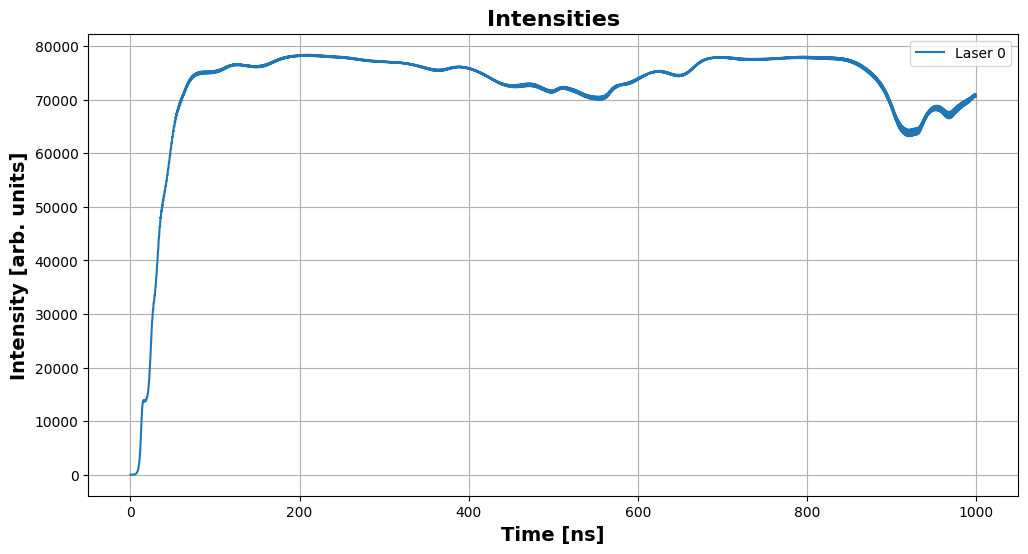

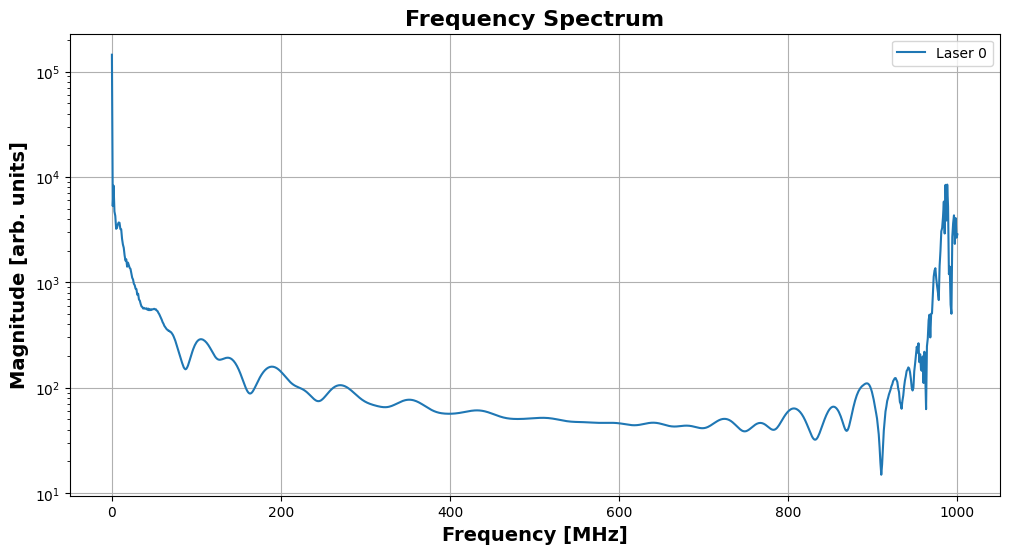

Avg normalized DC value of laser 0: 1.45e+05


In [42]:
plot_intensities(times, I_ts, filename="1laser_0p5kappa_1ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_0p5kappa_1ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt, cutoff=100e6)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_0p5kappa_1ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0p5kappa_1ns_threshold_intensity_fft.png")

### One Laser, Experiment #3: Intensity vs. Current Curve

In [16]:
# Sweep injection current between 0mA to twice the threshold current
#start_current = 0
#end_current = 2 * I_th
#di = 1e-3 # 1mA steps

start_current = I_th - 1e-3
end_current = I_th + 1e-3
di = 0.04e-3 # 0.04mA steps

current_sweep = np.arange(start_current, end_current, di)

# No self-coupling
kappas[0][0] = 0
taus[0][0] = 0

intensity_sweep = []
# tqdm adds a progress bar
for current in tqdm(current_sweep):
    I_injections = [] # Now a 2d list
    I_injections.append([current])
    times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

    # Record the laser's intensity at the end of the simulation when it has reached steady state
    intensity_sweep.append(I_ts[0][-1])

  0%|                                                       | 0/51 [00:00<?, ?it/s]/home/godwin/Documents/Summer 2025/Research/lasersim/.venv/lib64/python3.13/site-packages/jitcxde_common/_jitcxde.py:248: UserWarning: Differential equation does not include a delay term.
  self.compile_C()
/tmp/ipykernel_1086493/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)
100%|██████████████████████████████████████████████| 51/51 [01:06<00:00,  1.31s/it]


In [52]:
intensity_sweep = np.asarray(intensity_sweep)

# Linear regression to find slope efficiency
slope_eff, intercept, r, p, std_err = stats.linregress(current_sweep[current_sweep >= I_th], intensity_sweep[current_sweep >= I_th])

# Slope Efficiency: 1.225288e+07 Intercept: -2.125500e+05
def fit_single_laser_power(current):
    if current > I_th:
        return slope_eff * current + intercept
    else:
        return 0

single_laser_power_fit = list(map(fit_single_laser_power, current_sweep[current_sweep >= I_th]))
print(f"Slope Efficiency: {slope_eff:.6e} Intercept: {intercept:.6e}") # Used for the analysis function calc_single_laser_power()

Slope Efficiency: 1.225288e+07 Intercept: -2.125500e+05


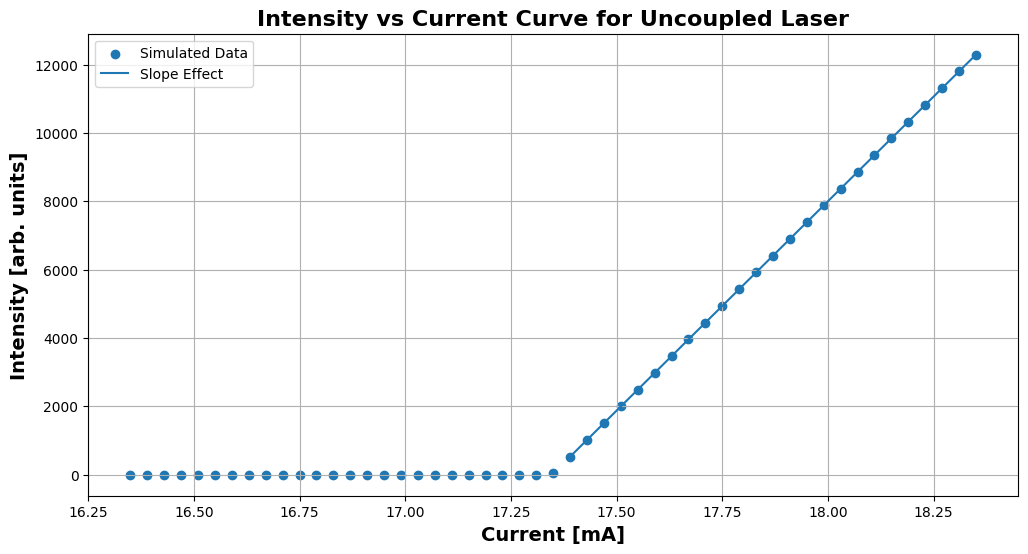

In [53]:
# Plot Intensity vs. Current curve
current_sweep_mA = current_sweep * 1e3

plt.figure(figsize=(12, 6))
plt.scatter(current_sweep_mA, intensity_sweep, label="Simulated Data")
plt.plot(current_sweep_mA[current_sweep >= I_th ], single_laser_power_fit, label="Slope Effect")

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curve for Uncoupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig("1laser_uncoupled_intensity_vs_current.png")
plt.show()

### One Laser, Experiment #4: Switching current on and off, no self-coupling

In [130]:
# switch every 40ns
I_times = np.arange(1e-9, sim_time, 40e-9)

# switch between completely off and 2 * I_th
#I_injections = []
#I_injection_0 = []
#for i in range(len(I_times)):
#    if i % 2 == 0:
#        I_injection_0.append(2 * I_th)
#    else:
#        I_injection_0.append(0)
#I_injections.append(I_injection_0)

# switch between 0.999 * I_th and 1.001 * I_th
I_injections = []
I_injection_0 = []
for i in range(len(I_times)):
    if i % 2 == 0:
        I_injection_0.append(0.999 * I_th)
    else:
        I_injection_0.append(1.001 * I_th)
I_injections.append(I_injection_0)

In [131]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

/tmp/ipykernel_739868/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


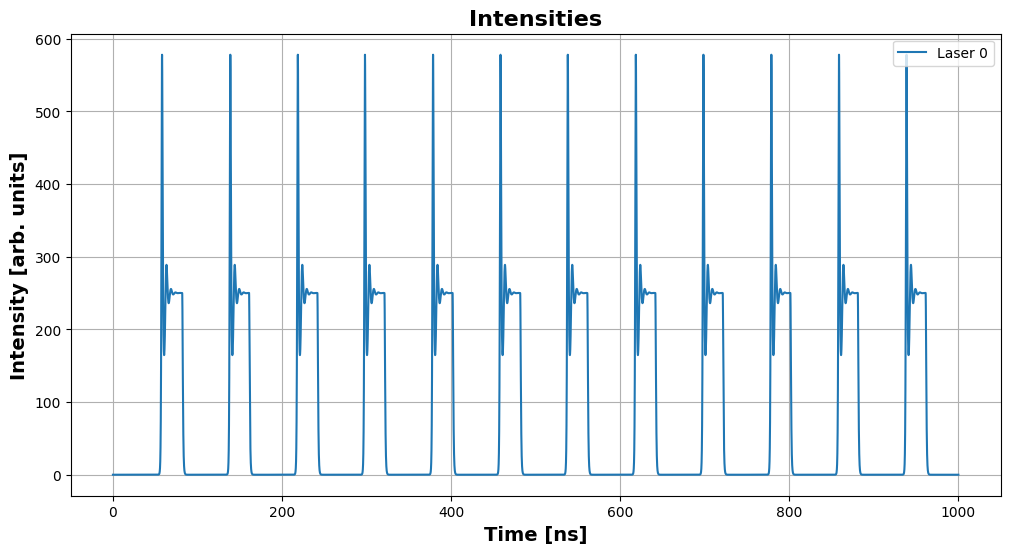

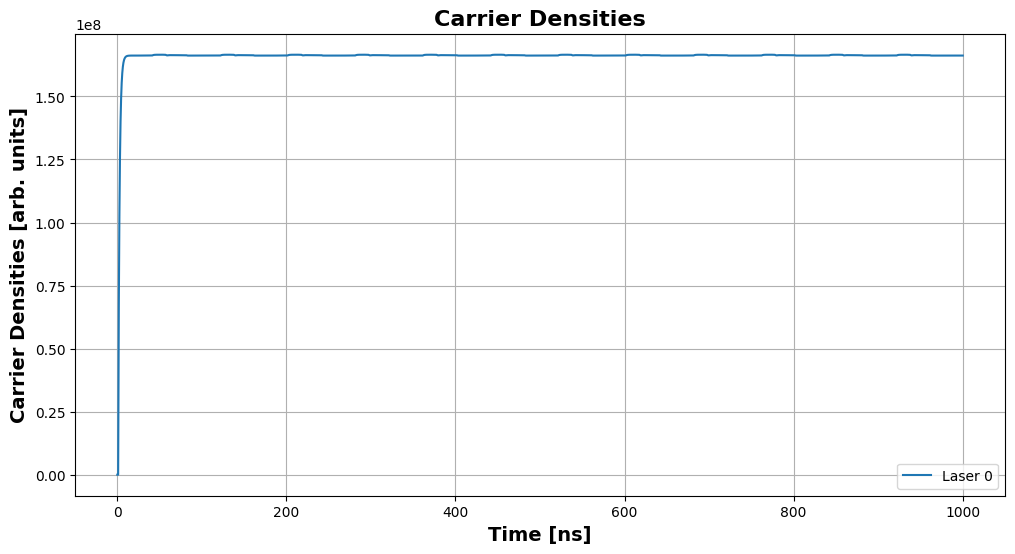

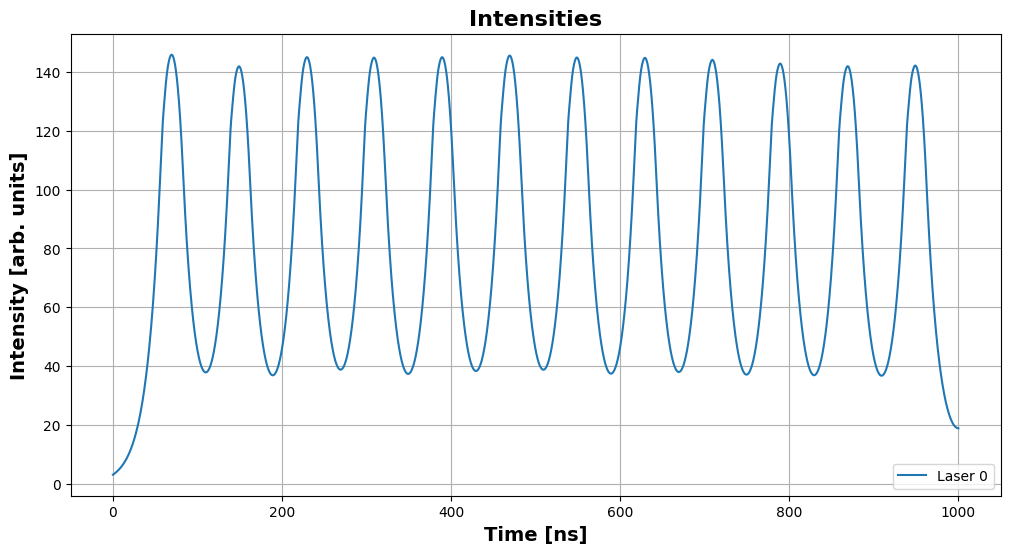

In [132]:
plot_intensities(times, I_ts, filename="1laser_switched_fast_0kappa_0ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_switched_fast_0kappa_0ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_switched_fast_0kappa_0ns_threshold_intensity_filtered.png")

#### Zoomed In

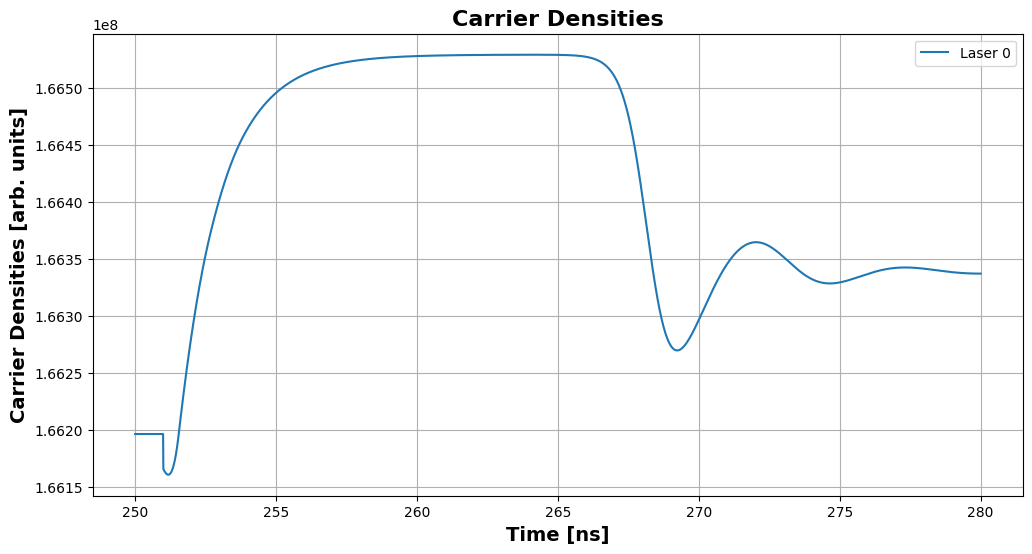

In [116]:
plot_carrier_densities(times, N_ts, 250, 280, filename="1laser_switched_fast_0p1shiftratio_0kappa_0ns_threshold_carrierdensity.png")

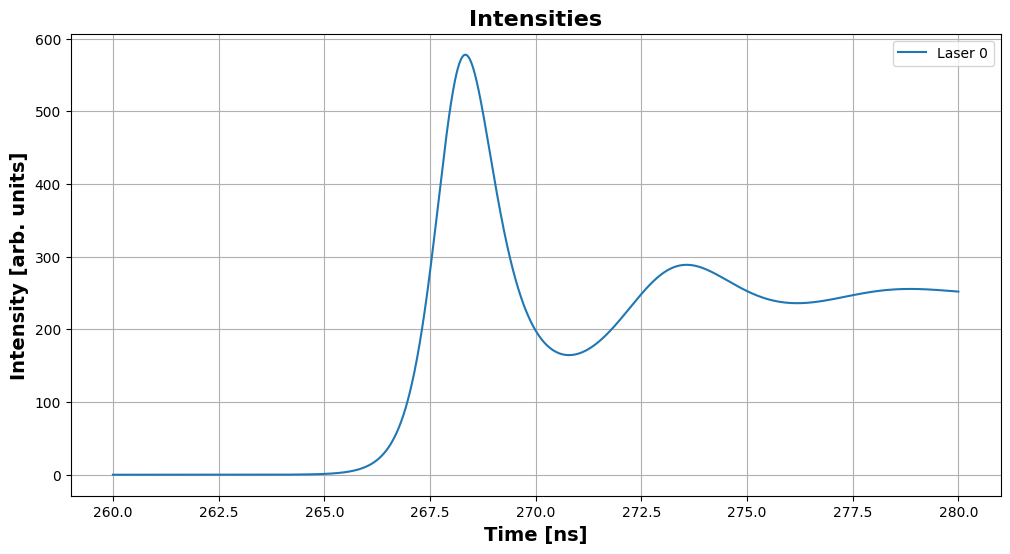

In [117]:
plot_intensities(times, I_ts, 260, 280, filename="1laser_switched_fast_0p1shiftratio_0kappa_0ns_threshold_intensity.png")

### One Laser, Experiment #5: effect of self-coupling and chaos on average power

In [89]:
# Set constants and ICs for a single, self coupled laser at 1mA above threshold
# We sweep kappa between 0 and 1 and observe its effect on power and whether or not it is chaotic (by looking at stdev)
start_kappa = 0
end_kappa = 1
dkappa = 0.1
kappa_sweep = np.arange(start_kappa, end_kappa, dkappa)

taus[0][0] = 1e-9 # 1 ns self-couple delay

# Injection currents in A
I_injections = [] # Now a 2d list
I_injections.append([I_th + 1e-3])

In [95]:
begin_time = 0 # in ns; cuts off initial transient

avg_intensity_sweep = []
stddev_sweep = []
all_times = [] # A list of list of lists
all_I_ts = [] # A list of list of lists
# tqdm adds a progress bar
for kappa in tqdm(kappa_sweep):
    kappas[0][0] = kappa
    times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

    # Record the laser's intensity after begin_time
    I_ts_truncated = I_ts[0][times >= (begin_time * 1e-9)]
    avg_intensity_sweep.append(np.mean(I_ts_truncated))
    stddev_sweep.append(np.std(I_ts_truncated))

    # Save raw data for individual inspection
    all_times.append(times)
    all_I_ts.append(I_ts)

  0%|                                                       | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_1086493/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)
100%|██████████████████████████████████████████████| 10/10 [01:02<00:00,  6.30s/it]


In [96]:
# Calculate fraction of uncoupled single laser power
slp = calc_single_laser_power(I_th + 1e-3)
print(f"Single laser power: {slp:.3e}")
fractional_intensity_sweep = np.asarray(avg_intensity_sweep) / slp

Single laser power: 1.225e+04


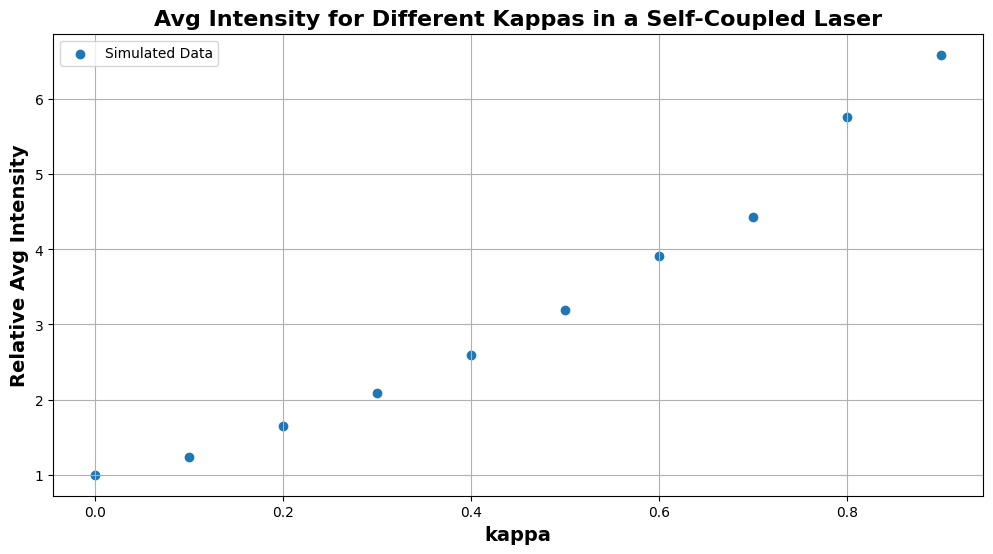

In [99]:
# Plot Avg Intensity vs. kappa curve
plt.figure(figsize=(12, 6))
#plt.scatter(kappa_sweep, avg_intensity_sweep, label="Simulated Data") # absolute intensity
plt.scatter(kappa_sweep, fractional_intensity_sweep, label="Simulated Data") # relative intensity to uncoupled laser

plt.xlabel("kappa", fontsize=14, fontweight='bold')
# Fraction of Intensity Compared to Uncoupled Laser
plt.ylabel("Relative Avg Intensity", fontsize=14, fontweight='bold')
plt.title("Avg Intensity for Different Kappas in a Self-Coupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig("1laser_intensity_vs_kappa.png")
plt.show()

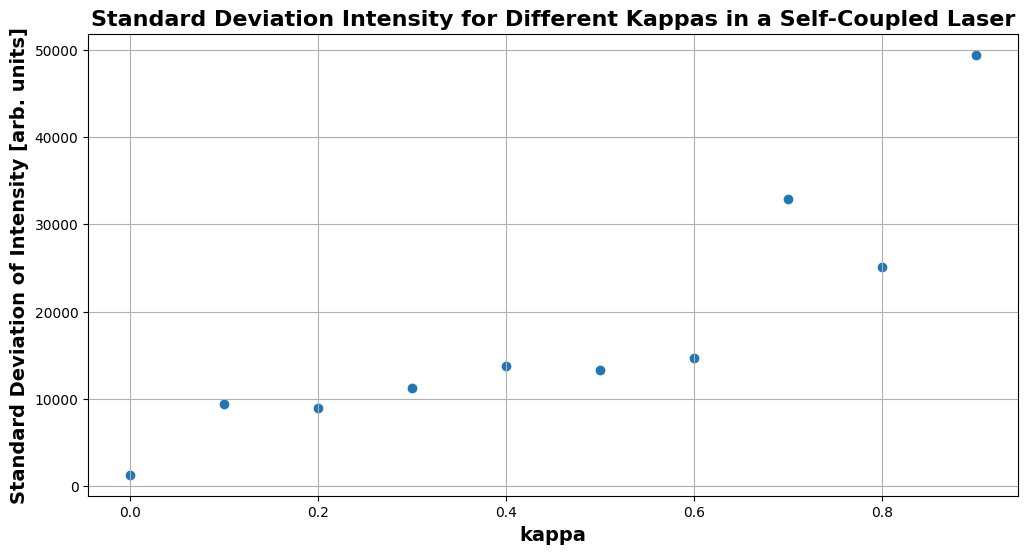

In [100]:
# Plot standard deviation vs. kappa curve
# Used to identify chaos
plt.figure(figsize=(12, 6))
plt.scatter(kappa_sweep, stddev_sweep)

plt.xlabel("kappa", fontsize=14, fontweight='bold')
plt.ylabel("Standard Deviation of Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Standard Deviation Intensity for Different Kappas in a Self-Coupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)

plt.savefig("1laser_stddev_vs_kappa.png")
plt.show()

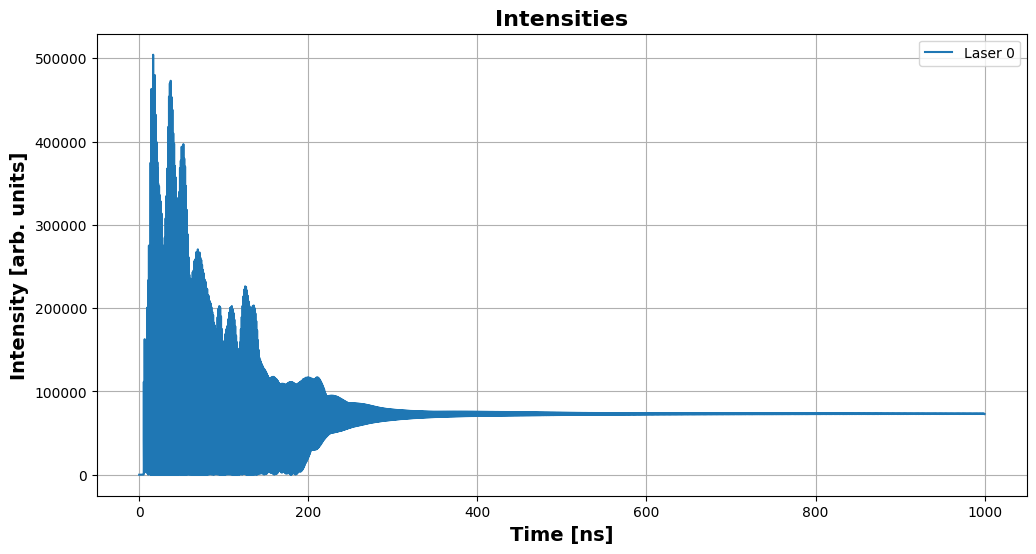

In [107]:
# Inspect time plots of individual values of kappa
trial_idx = 8

plot_intensities(all_times[trial_idx], all_I_ts[trial_idx], begin_time=begin_time, filename="1laser_0kappa_0ns_threshold_intensity.png")
#plot_carrier_densities(times, N_ts, begin_time=begin_time, filename="1laser_0kappa_0ns_threshold_carrierdensity.png")

#filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt)
#freqs, spectrums = take_fft(times, I_ts, dt)

#plot_intensities(times, filtered_I_ts, begin_time=begin_time, filename="1laser_0kappa_0ns_threshold_intensity_filtered.png")
#plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0kappa_0ns_threshold_intensity_fft.png")

### One Laser, Experiment #6: small (<1ns) coupling delays

In [49]:
# Set constants and ICs for a single, self coupled laser at 1mA above threshold
kappas[0][0] = 1
taus[0][0] = 0.1e-9 # 0.1 ns self-couple delay (light travels about 3cm)

# Injection currents in A
I_injections = [] # Now a 2d list
I_injections.append([I_th + 1e-3])

In [50]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

/tmp/ipykernel_1540549/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


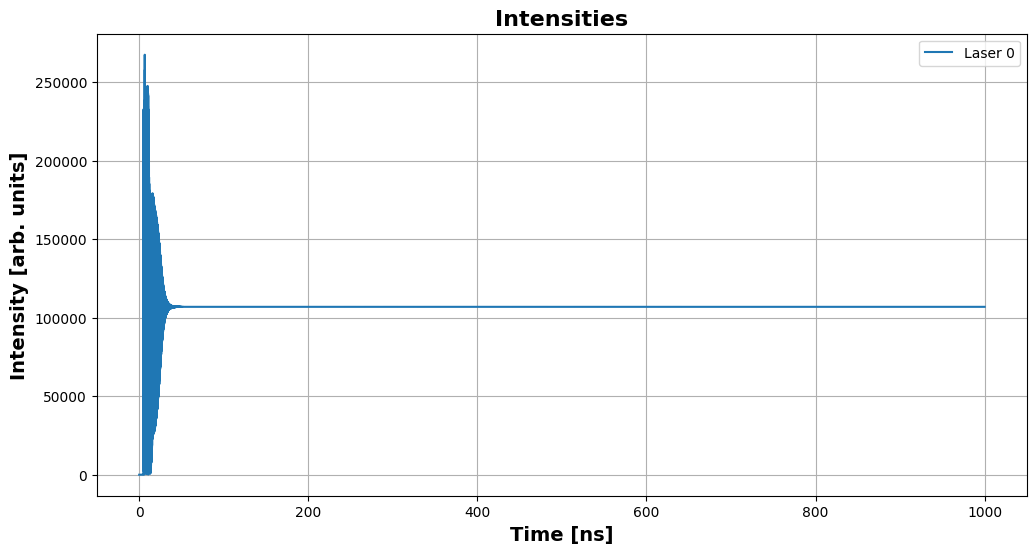

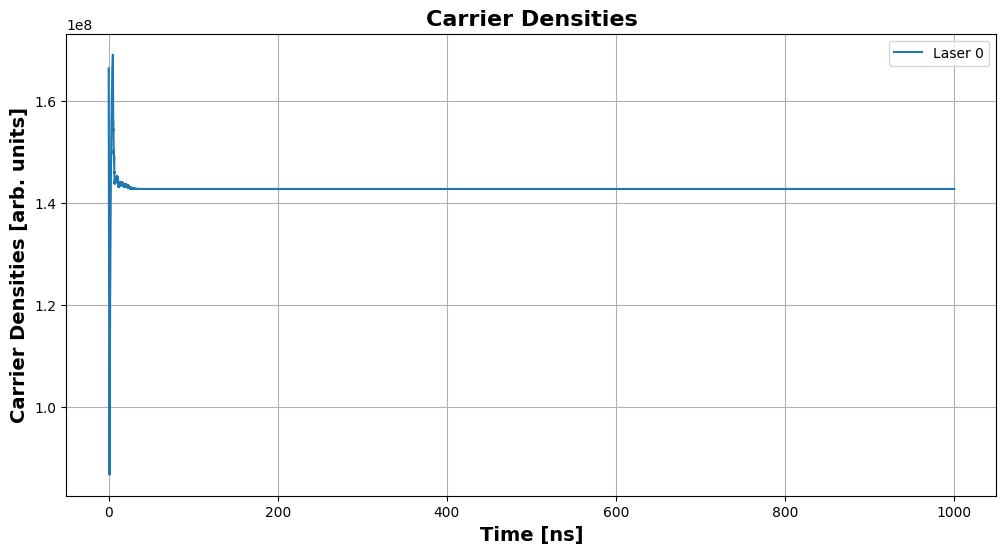

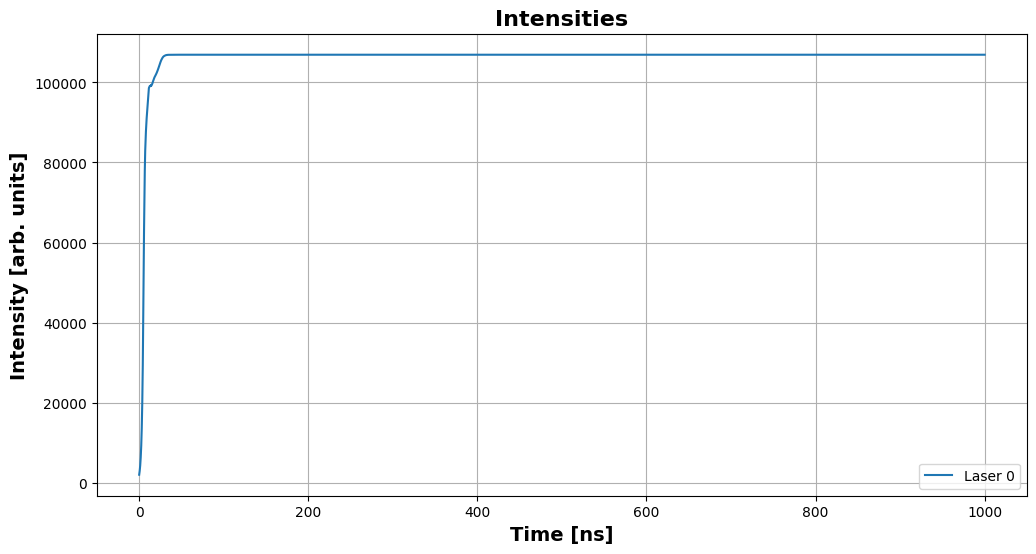

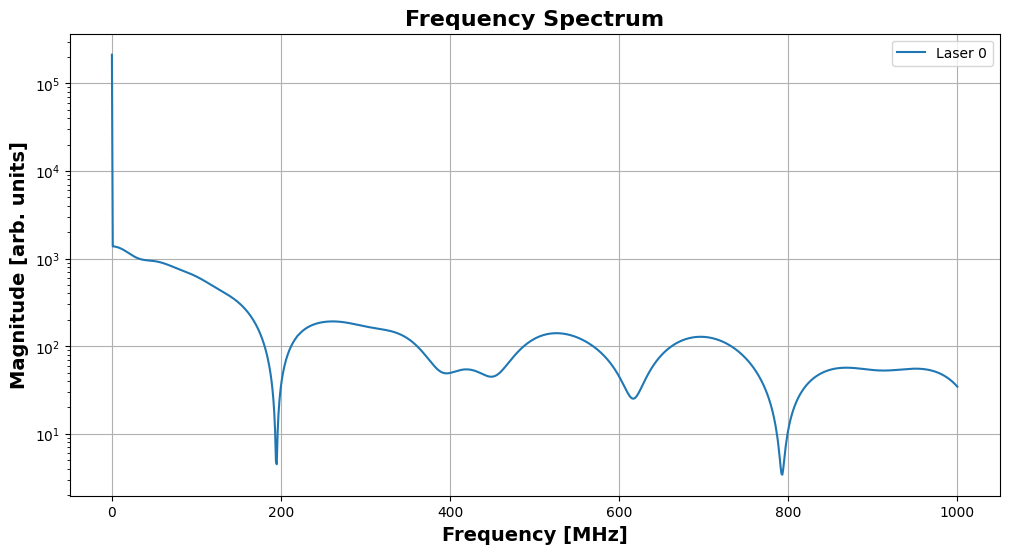

Avg normalized DC value of laser 0: 2.12e+05


In [51]:
plot_intensities(times, I_ts, filename="1laser_0p5kappa_0p1ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_0p5kappa_0p1ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt, cutoff=100e6)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_0p5kappa_0p1ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0p5kappa_0p1ns_threshold_intensity_fft.png")

### One Laser, Experiment #7: 

## Two Laser Simulations

### Set Initial and Default Conditions

In [63]:
num_lasers = 2

# Angular frequencies of lasers in rad/s
# Frequency differences are calculated in equations
omegas = [omega_typ for i in range(num_lasers)]

# Coupling constants (initialized to no coupling)
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575
taus = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Delay time in s

# Injection times in s (at least one initial time is required)
# For some reason, initial time = 0 doesn't work so we set it to 1ns
I_times = [1e-9]

# Initial conditions for 2 laser case (can be used for any of above cases)
E_R_0s = [1e-6, 1e-6]
E_I_0s = [0, 0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init, N_init]

# Introduce some asymmetry in initial conditions
E_R_0s[0] += 10e-6
E_R_0s[1] -= 10e-6

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### Two Lasers, Experiment #1: criteria for chaos

In [108]:
# Two weakly coupled lasers at threshold
I_injections = []
I_injections.append([I_th])
I_injections.append([I_th])

# Set coupling constants for 2 weakly inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.1
taus[0][1] = taus[1][0] = 0.01e-9
#taus[0][1] = taus[1][0] = 0

In [109]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

/tmp/ipykernel_1879328/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


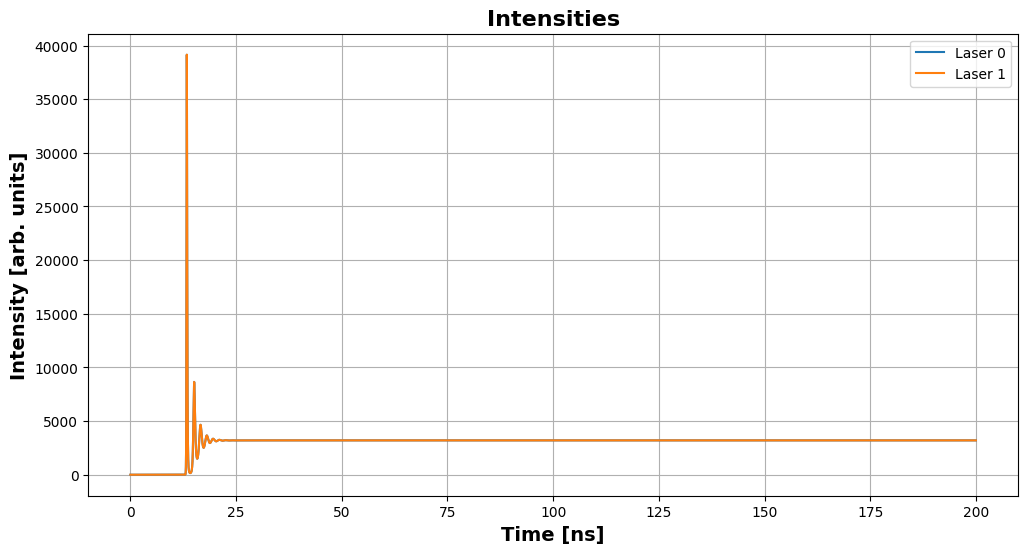

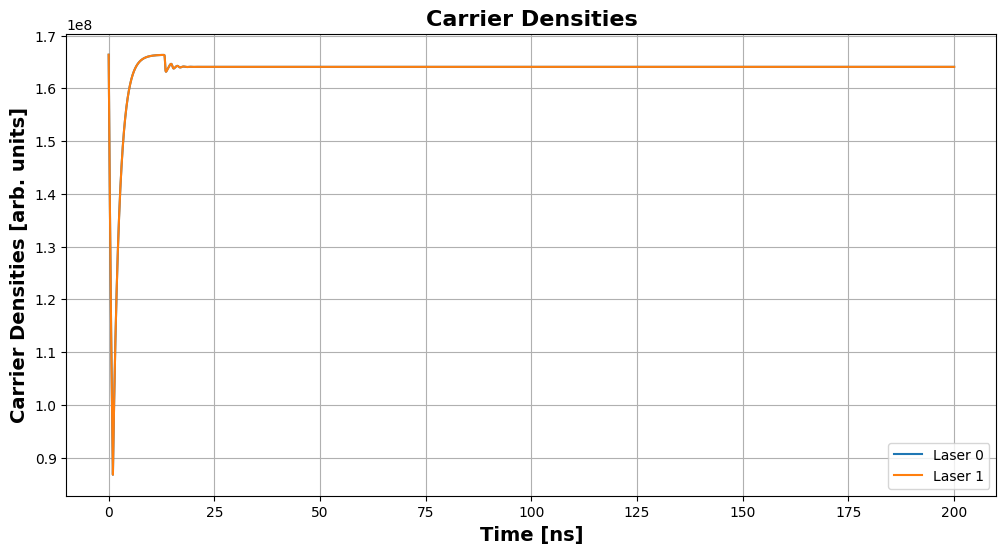

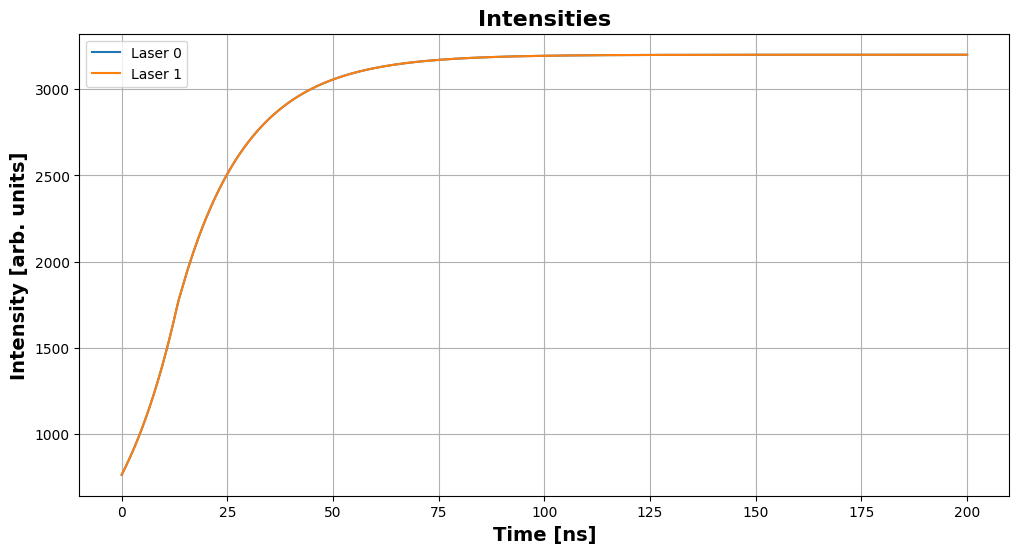

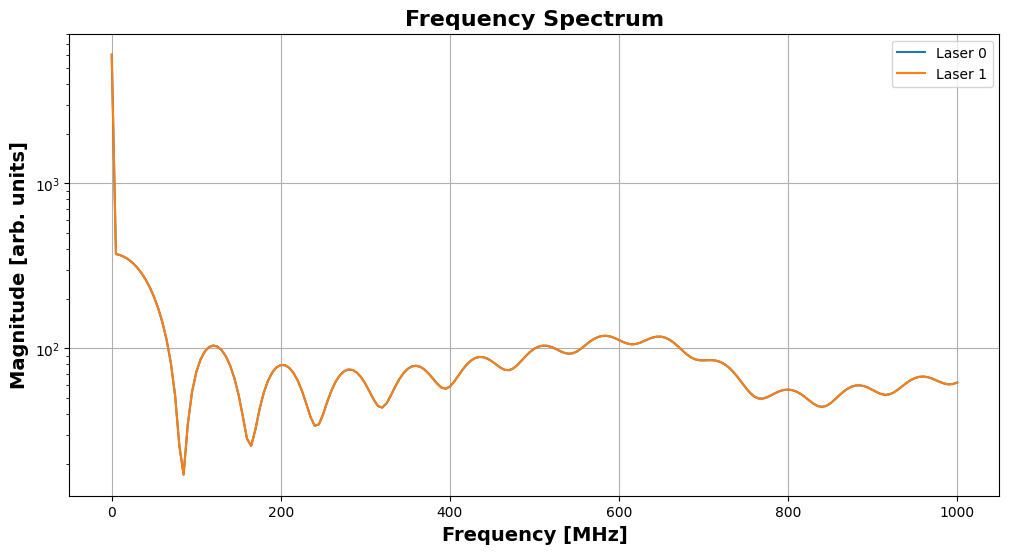

Avg normalized DC value of laser 0: 6.03e+03
Avg normalized DC value of laser 1: 6.03e+03


In [110]:
plot_intensities(times, I_ts, filename="2laser_0p5kappa_1ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="2laser_0p5kappa_1ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt, cutoff=10e6)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="2laser_0p5kappa_1ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="2laser_0p5kappa_1ns_threshold_intensity_fft.png")

In [61]:
mean, rel_stddev = calc_mean_and_relative_stddev(times, I_ts, 100)
print(mean, rel_stddev)

[np.float64(337.65885766841853), np.float64(337.65885766841853)] [np.float64(2.522101876327434e-05), np.float64(2.522101876327405e-05)]


### Two Lasers, Experiment #2: finding how one laser's output changes the other's threshold

In [64]:
# Set coupling constants for 2 inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.1
# The smaller the tau, the more coupling is needed for chaos. We don't want chaos here, so it's small.
#taus[0][1] = taus[1][0] = 0.1e-9
taus[0][1] = taus[1][0] = 0

In [111]:
# For different values of laser 0 current, sweep laser 1 current.
# Find the x-intercept (new threshold current) for each laser 0 current value
# Repeat for different values of kappa

begin_time = 100 # start recording data from this time in ns
chaos_rel_stddev_threshold = 0.01 # if the stddev is larger than 1% of the mean, there is potentially chaos in that data

start_current_0 = I_th - 5e-3
end_current_0 = I_th + 10e-3
dcurrent_0 = 2e-3
current_0_sweep = np.arange(start_current_0, end_current_0, dcurrent_0)

start_current_1 = I_th - 1e-3
end_current_1 = I_th + 1e-3
dcurrent_1 = 0.1e-3
current_1_sweep = np.arange(start_current_1, end_current_1, dcurrent_1)

intensity_threshold = 1000 # in arbitrary units; the laser is considered turned on when it reaches this value

# Calculated data
I_thresholds = []
slope_efficiencies = []

# Save the raw data too so I don't have to rerun this simulation
all_avg_intensities_0 = []
all_avg_intensities_1 = []

for current_0 in tqdm(current_0_sweep):
    avg_intensities_0 = []
    avg_intensities_1 = []
    for current_1 in tqdm(current_1_sweep, leave=False):
        I_injections = []
        I_injections.append([current_0])
        I_injections.append([current_1])

        times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, I_times, sim_time, dt, ics)

        mean, rel_stddev = calc_mean_and_relative_stddev(times, I_ts, begin_time)
        if (mean[1] > intensity_threshold) and (rel_stddev[1] > chaos_rel_stddev_threshold):
            print(f"Potential chaos detected at I_0={current_0:.6f}, I_1={current_1:.6f}")
            
        avg_intensities_0.append(mean[0])
        avg_intensities_1.append(mean[1])

    # Find where intensity first exceeds the intensity threshold
    exceed_idx = -1
    for i in range(len(avg_intensities_1)):
        if avg_intensities_1[i] > intensity_threshold:
            exceed_idx = i
            break
    #print("Exceed Index:", exceed_idx)
    if exceed_idx == -1:
        print(f"Laser 1 never turned on at I_0={current_0:.6f}. Stopping.")
        break

    # Do a linear regression to fit the slope for data points after exceed_idx
    # Linear regression to find slope efficiency
    slope_eff, intercept, r, p, std_err = stats.linregress(current_1_sweep[exceed_idx:], avg_intensities_1[exceed_idx:])
    if r**2 < 0.9:
        print(f"Linear regression had a bad fit at at I_0={current_0:.6f}.")
    
    threshold = -1 * intercept / slope_eff

    I_thresholds.append(threshold)
    slope_efficiencies.append(slope_eff)

    # Save raw data for plotting
    all_avg_intensities_0.append(avg_intensities_0)
    all_avg_intensities_1.append(avg_intensities_1)
    

  0%|                                                       | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_1879328/2615337938.py:50: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)

100%|████████████████████████████████████████████████| 8/8 [05:57<00:00, 44.68s/it]


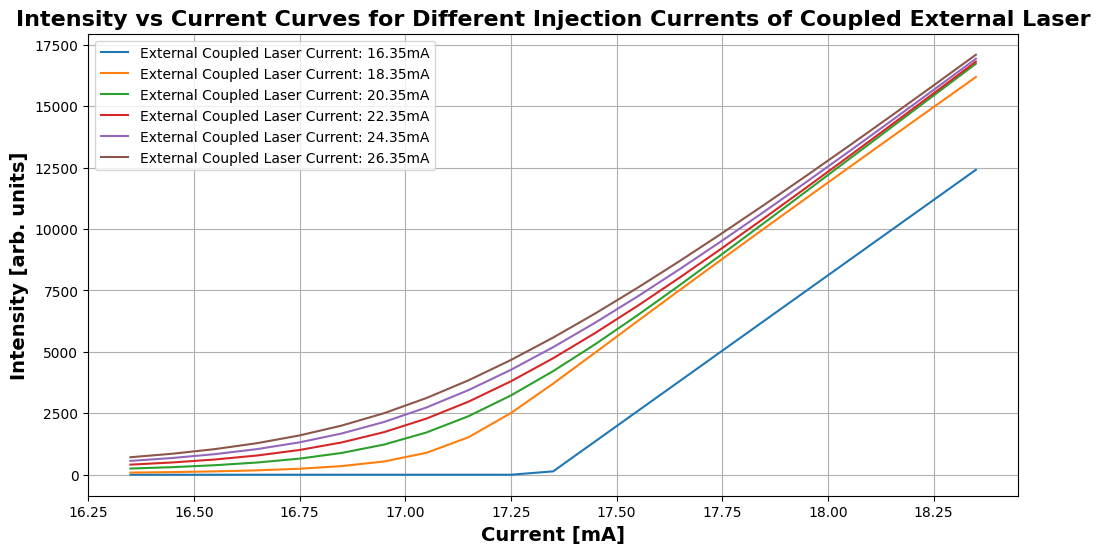

In [117]:
# Plot intensity_1 vs. current_1 curves for different values of current_0

# Plot Intensity vs. Current curve
current_0_sweep_mA = current_0_sweep * 1e3
current_1_sweep_mA = current_1_sweep * 1e3

plt.figure(figsize=(12, 6))

for i in range(len(current_0_sweep_mA)):
    if (i < 2): # Used to exclude low-current results that just look like the uncoupled intensity vs current curve
        continue
    plt.plot(current_1_sweep_mA, all_avg_intensities_1[i], label=f"External Coupled Laser Current: {current_0_sweep_mA[i]:.2f}mA")

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curves for Different Injection Currents of Coupled External Laser",fontsize=16, fontweight='bold')
plt.grid(True)
plt.legend()

plt.savefig("intensity_vs_current_for_0p1kappa_0tau_external_injection.png")
plt.show()

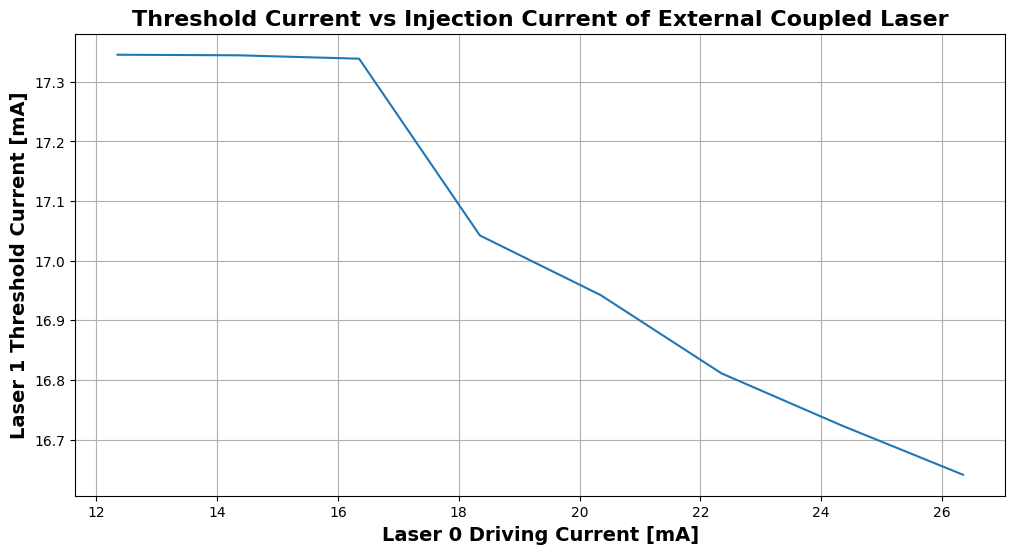

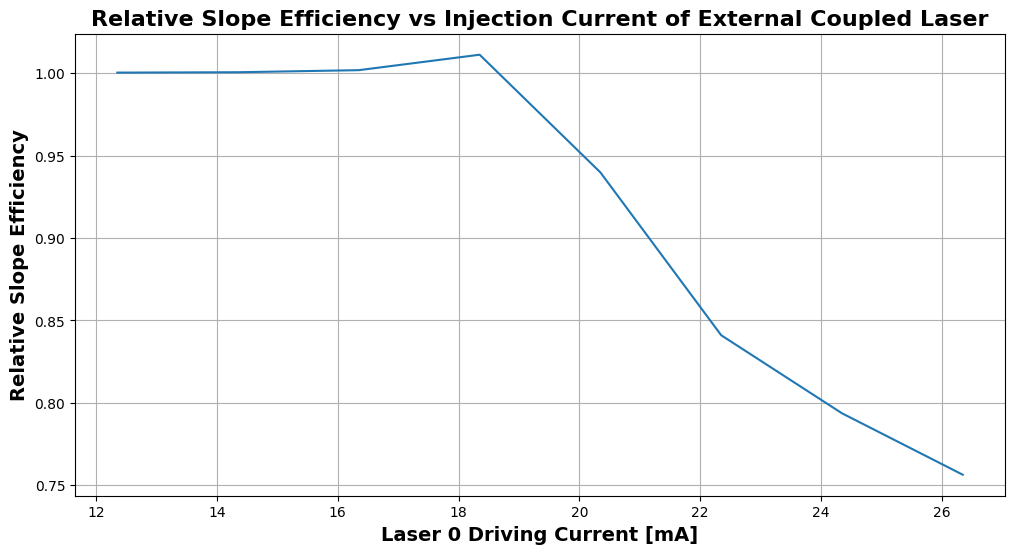

In [113]:
# Plot threshold current of laser 1 as a function of laser 0 current
current_0_sweep_mA = current_0_sweep * 1e3
I_thresholds_mA = np.multiply(I_thresholds, 1e3) # what is this strange numpy array behavior?!

plt.figure(figsize=(12, 6))
plt.plot(current_0_sweep_mA, I_thresholds_mA)
plt.xlabel("Laser 0 Driving Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Laser 1 Threshold Current [mA]", fontsize=14, fontweight='bold')
plt.title("Threshold Current vs Injection Current of External Coupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)

#plt.savefig("1laser_uncoupled_intensity_vs_current.png")
plt.show()

# Plot slope efficiency of laser 1 as a function of laser 0 current
relative_slope_efficiency = np.divide(slope_efficiencies, standard_slope_efficiency)

plt.figure(figsize=(12, 6))
plt.plot(current_0_sweep_mA, relative_slope_efficiency)
plt.xlabel("Laser 0 Driving Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Relative Slope Efficiency", fontsize=14, fontweight='bold')
plt.title("Relative Slope Efficiency vs Injection Current of External Coupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)

#plt.savefig("1laser_uncoupled_intensity_vs_current.png")
plt.show()

### Two Lasers, Experiment #3: effect of mismatches in laser optical frequency

## Three Laser Simulations